# <u>Advanced AI-Based Hair Color Manipulation Using PyTorch, OpenCV, and Background Removal Techniques</u>

### Project by: Suprathick Reddy S

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading pac

<ipython-input-7-b767d1cd57dd>:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(cp))


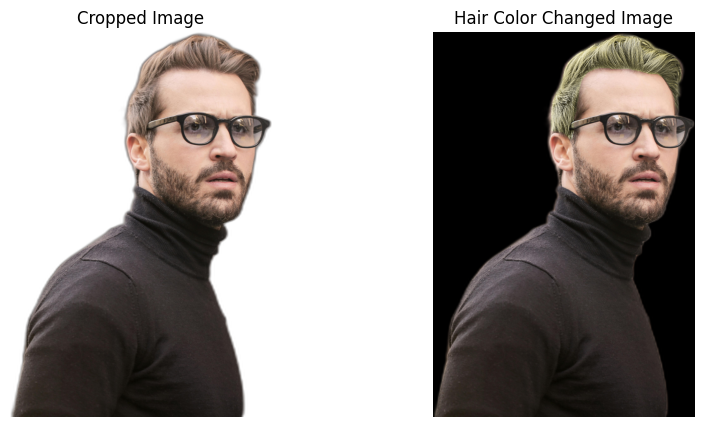

<ipython-input-7-b767d1cd57dd>:200: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  cropped_image = cropped_image.resize((w, h), Image.ANTIALIAS)


Stitched image saved to /content/stitched_image_no_black_background_final_corrected.jpg


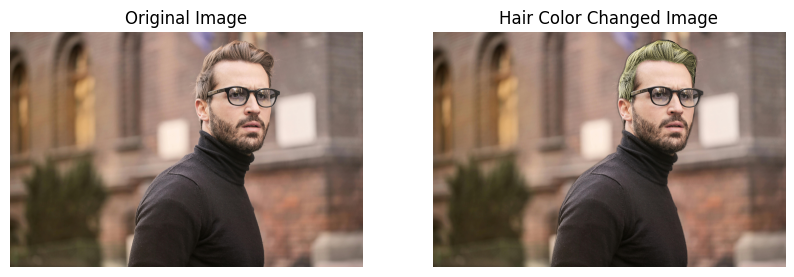

Plot saved to /content/original_vs_stitched.png


In [7]:
# Installing required packages
!apt-get update
!apt-get install -y cmake
!pip install dlib
!pip install --upgrade pip
!pip install rembg

# Git cloning
!git clone https://github.com/zllrunning/face-makeup.PyTorch.git
!git clone https://gist.github.com/757e63802b0b28fbdab9d98b2e646ac2.git
%cd face-makeup.PyTorch # Envirnoment setup

# Importing necessary libraries
import os
import cv2
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from skimage.filters import gaussian
import matplotlib.pyplot as plt
from rembg import remove
from model import BiSeNet

# Function to remove background from image
def remove_background(input_image_path, output_image_path, mask_path):
    image = Image.open(input_image_path).convert("RGBA")  # Ensure image is RGBA
    image_no_bg = remove(image)
    image_no_bg.save(output_image_path)
    np_image = np.array(image_no_bg)
    gray = cv2.cvtColor(np_image, cv2.COLOR_RGBA2GRAY)
    _, binary_mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    cv2.imwrite(mask_path, binary_mask)
    print("Mask saved to", mask_path)

# Function to detect and crop person
def detect_and_crop_person(input_image_path, final_output_path):
    directory = os.path.dirname(input_image_path)
    base_name = os.path.splitext(os.path.basename(input_image_path))[0]
    output_image_suffix = 'cropped'  # suffix can be changed or made dynamic
    mask_path = os.path.join(directory, f"{base_name}_mask.png")
    temp_path = os.path.join(directory, 'temp_no_bg.png')
    remove_background(input_image_path, temp_path, mask_path)
    image = Image.open(temp_path).convert("RGBA")  # Ensure image is RGBA
    np_image = np.array(image)
    gray = cv2.cvtColor(np_image, cv2.COLOR_RGBA2GRAY)
    _, binary_mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        bbox_path = os.path.join(directory, f"{base_name}_bbox.txt")
        with open(bbox_path, 'w') as bbox_file:
            bbox_file.write(f"{x},{y},{w},{h}")
        print("Bounding box coordinates saved to", bbox_path)
        cropped_image = image.crop((x, y, x + w, y + h))
        cropped_image.save(final_output_path, "PNG")
        print("Cropped image saved to", final_output_path)
    else:
        print("No contours found. The image might be empty or incorrectly processed.")

input_image_path = '/content/pexels-olly-874158.jpg'  # You can change the path to your original image path here
final_output_path = '/content/pexels-olly-874158_cropped.png'
detect_and_crop_person(input_image_path, final_output_path)

# Function to evaluate the image with a model
def evaluate(image_path='./imgs/116.jpg', cp='cp/79999_iter.pth'):
    n_classes = 19
    net = BiSeNet(n_classes=n_classes)
    net.cuda()
    net.load_state_dict(torch.load(cp))
    net.eval()

    to_tensor = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

    with torch.no_grad():
        img = Image.open(image_path).convert("RGB")  # Ensure image is RGB
        image = img.resize((512, 512), Image.BILINEAR)
        img = to_tensor(image)
        img = torch.unsqueeze(img, 0)
        img = img.cuda()
        out = net(img)[0]
        parsing = out.squeeze(0).cpu().numpy().argmax(0)
        return parsing

# Function to sharpen the image
def sharpen(img):
    img = img * 1.0
    gauss_out = gaussian(img, sigma=5, channel_axis=-1)
    alpha = 1.5
    img_out = (img - gauss_out) * alpha + img
    img_out = img_out / 255.0
    img_out = np.clip(img_out, 0, 1)
    img_out = img_out * 255
    return np.array(img_out, dtype=np.uint8)

# Function to change hair color
def hair(image, parsing, part=17, color=[230, 50, 20]):
    b, g, r = color
    tar_color = np.zeros_like(image)
    tar_color[:, :, 0] = b
    tar_color[:, :, 1] = g
    tar_color[:, :, 2] = r

    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    tar_hsv = cv2.cvtColor(tar_color, cv2.COLOR_BGR2HSV)

    if part == 12 or part == 13:
        image_hsv[:, :, 0:2] = tar_hsv[:, :, 0:2]
    else:
        image_hsv[:, :, 0:1] = tar_hsv[:, :, 0:1]

    changed = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2BGR)

    if part == 17:
        changed = sharpen(changed)

    if parsing.shape != image.shape[:2]:
        parsing = cv2.resize(parsing, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Ensuring both 'changed' and 'image' have the same shape and number of channels
    if changed.shape[2] == 3:
        changed = cv2.cvtColor(changed, cv2.COLOR_BGR2BGRA)
    if image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)

    changed[parsing != part] = image[parsing != part]
    return changed

# Function to parse arguments
def parse_args():
    parse = argparse.ArgumentParser()
    parse.add_argument('--img-path', default="/content/pexels-olly-874158_cropped.png")
    args, unknown = parse.parse_known_args()
    return args

# Main function to run the script
if __name__ == '__main__':
    args = parse_args()

    table = {
        'hair': 17,
        'upper_lip': 12,
        'lower_lip': 13
    }

    image_path = args.img_path
    cp = '/content/face-makeup.PyTorch/cp/79999_iter.pth'

    image = Image.open(image_path).convert("RGBA")
    np_image = np.array(image)
    if np_image.shape[2] == 4:
        ori = cv2.cvtColor(np_image, cv2.COLOR_RGBA2BGRA)
    else:
        ori = cv2.cvtColor(np_image, cv2.COLOR_RGB2BGR)

    parsing = evaluate(image_path, cp)

    if parsing.shape != ori.shape[:2]:
        parsing = cv2.resize(parsing, (ori.shape[1], ori.shape[0]), interpolation=cv2.INTER_NEAREST)

    parts = [table['hair']]
    colors = [[0, 220, 255]]

    for part, color in zip(parts, colors):
        ori = hair(ori, parsing, part, color)

    output_dir = '/content/face-makeup.PyTorch/vis_results'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    output_image_path = os.path.join(output_dir, 'result.png')  # Saving as PNG to retain alpha channel
    cv2.imwrite(output_image_path, ori)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Cropped Image')
    plt.imshow(np_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Hair Color Changed Image')
    plt.imshow(cv2.cvtColor(ori, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()

# Function to stitch back the cropped image to the original image without black background
def stitch_back_to_original(original_image_path, cropped_image_path, bbox_path):
    original_image = Image.open(original_image_path).convert("RGBA")
    cropped_image = Image.open(cropped_image_path).convert("RGBA")

    with open(bbox_path, 'r') as bbox_file:
        x, y, w, h = map(int, bbox_file.read().split(','))

    # Ensuring the cropped image retains its alpha channel
    cropped_image = cropped_image.resize((w, h), Image.ANTIALIAS)

    # Creating a mask using the alpha channel of the cropped image
    mask = cropped_image.split()[3]

    # Pasting the cropped image onto the original image using the alpha channel as mask
    original_image.paste(cropped_image, (x, y), mask)

    output_image_path = os.path.join(os.path.dirname(original_image_path), "stitched_image_no_black_background_final_corrected.jpg")
    original_image.convert("RGB").save(output_image_path)
    print("Stitched image saved to", output_image_path)

def plot_and_save_images(original_image_path, stitched_image_path, output_plot_path):
      original_image = Image.open(original_image_path)
      stitched_image = Image.open(stitched_image_path)

      # Plotting the images side by side
      plt.figure(figsize=(10, 5))
      plt.subplot(1, 2, 1)
      plt.title('Original Image')
      plt.imshow(original_image)
      plt.axis('off')

      plt.subplot(1, 2, 2)
      plt.title('Hair Color Changed Image')
      plt.imshow(stitched_image)
      plt.axis('off')

      # Saving the plot as an image
      plt.savefig(output_plot_path, format='png')
      plt.show()

      print("Plot saved to", output_plot_path)

# Main function to stitch back the image
if __name__ == '__main__':
    input_image_path = '/content/pexels-olly-874158.jpg'  # You can change the path to your original image path here
    cropped_image_path = '/content/face-makeup.PyTorch/vis_results/result.png'
    bbox_path = '/content/pexels-olly-874158_bbox.txt'
    stitched_image_path = '/content/stitched_image_no_black_background_final_corrected.jpg'
    output_plot_path = '/content/original_vs_stitched.png'

    stitch_back_to_original(input_image_path, cropped_image_path, bbox_path)
    plot_and_save_images(input_image_path, stitched_image_path, output_plot_path)